In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import os
import warnings

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
bs=32

In [9]:
path = "./data"
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
classes = os.listdir(train_path)

## Process Data

In [10]:
test_csv = os.path.join(path, 'test.csv')       # Path to test.csv file
test_images = os.path.join(path, 'test')        # Path to test images folder

In [11]:
classes

['Adults', 'Teenagers', 'Toddler']

In [7]:
np.random.seed(43)
data = ImageDataBunch.from_folder(path,
                                  train='train',
                                  test='test',
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4, bs=16,
                                  no_check=True
                                 ).normalize(imagenet_stats)

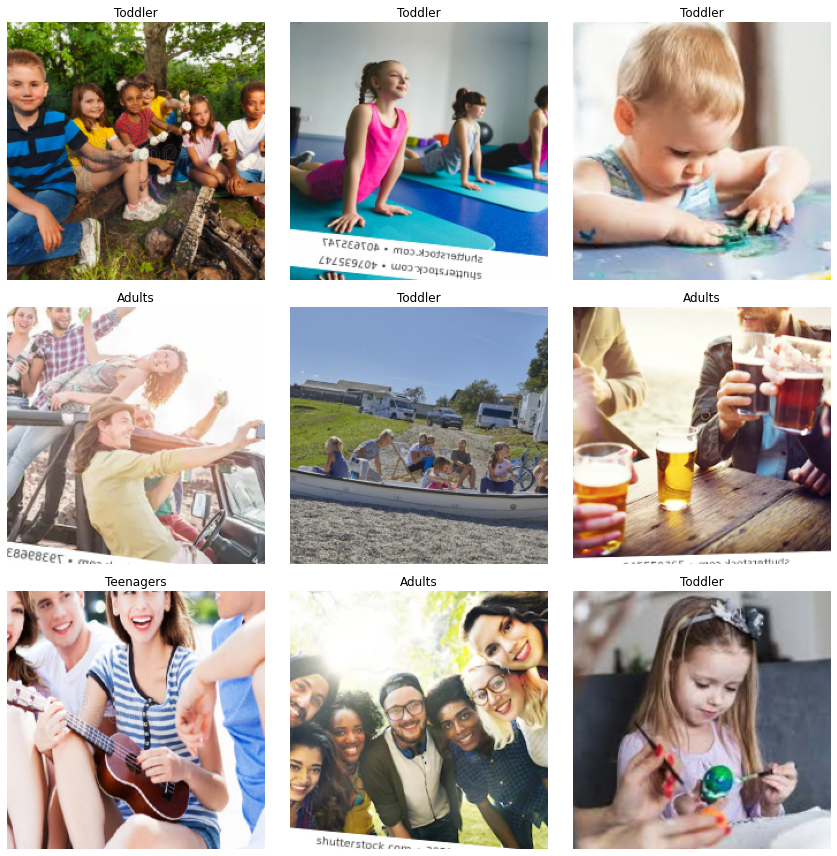

In [8]:
data.show_batch(rows=3, size=(7, 10))

In [8]:
print(data.classes)
len(data.classes),data.c

['Adults', 'Teenagers', 'Toddler']


(3, 3)

## Training And Testing Models

## Resnet 34

In [41]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [11]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.436912,0.821961,0.330357,0.669643,02:20
1,1.214075,0.895999,0.308929,0.691071,02:16
2,1.028796,0.720805,0.319643,0.680357,02:15
3,0.870962,0.710543,0.308929,0.691071,02:20
4,0.803746,0.660169,0.305357,0.694643,02:11
5,0.729427,0.674780,0.314286,0.685714,02:18
6,0.665171,0.656707,0.287500,0.712500,02:17
7,0.598369,0.614432,0.266071,0.733929,01:22
8,0.575423,0.611716,0.262500,0.737500,01:27
9,0.554344,0.614914,0.267857,0.732143,01:27


In [12]:
learn.save('stage-1')

## Testing Resnet 34


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

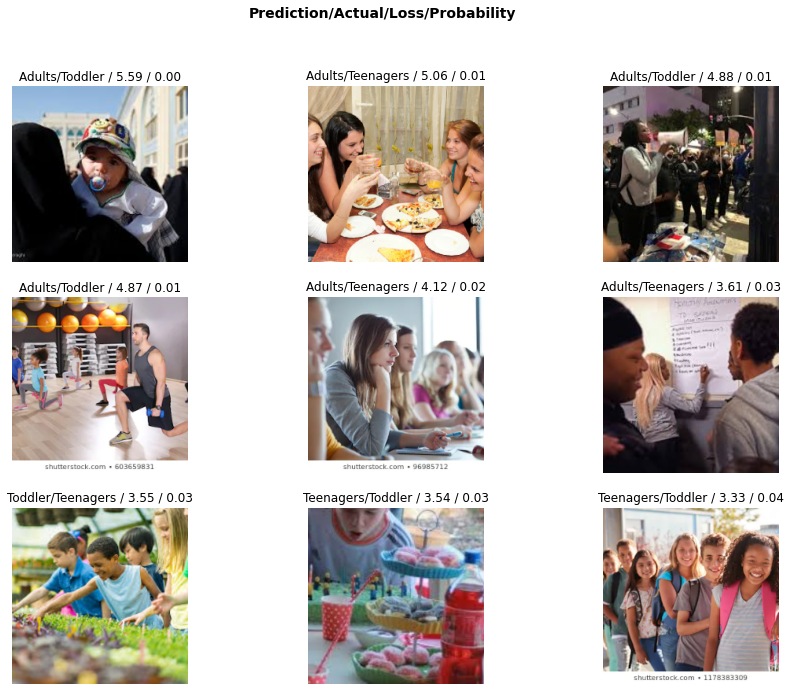

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

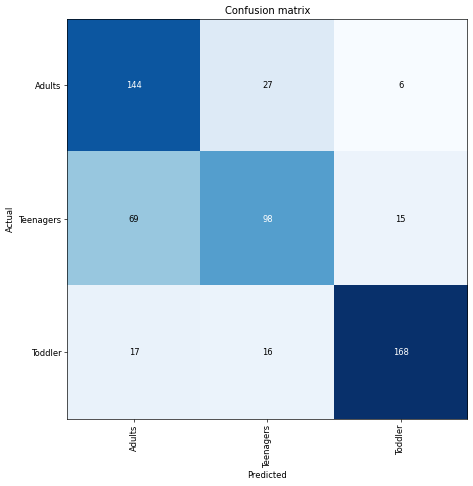

In [17]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('Teenagers', 'Adults', 69),
 ('Adults', 'Teenagers', 27),
 ('Toddler', 'Adults', 17),
 ('Toddler', 'Teenagers', 16),
 ('Teenagers', 'Toddler', 15),
 ('Adults', 'Toddler', 6)]

## Resnet 34 Fine Tuning


In [42]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (2243 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Adults,Adults,Adults,Adults
Path: data;

Valid: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Toddler,Adults,Adults,Adults
Path: data;

Test: LabelList (314 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (con

Prediction Result: Toddler


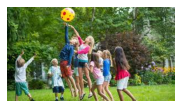

In [46]:
tst = open_image('./data/test/Img5336.jpg')

tst.show()
pred_class,pred_idx,outputs = learn.predict(tst)
print(f"Prediction Result: {pred_class.obj}")

In [47]:
preds, y = learn.get_preds(data.test_ds)

In [58]:
len(preds)

2243

# Test Resnet34 Fine Tuned

In [62]:
filenames = pd.read_csv(test_csv)
filenames = np.array(filenames)

In [75]:
res = []
for img in filenames:
    path = os.path.join(test_path, str(img[0]))
    tst = open_image(path)
    pred_class,pred_idx,outputs = learn.predict(tst)
    pred = pred_class.obj
    res.append(pred_class.obj)

In [76]:
res[:5]

['Adults', 'Teenagers', 'Teenagers', 'Teenagers', 'Toddler']

In [79]:
test_csv

'./data\\test\\Img6290.jpg\\test.csv'

In [86]:
def save_results(results):
    images = pd.read_csv('./data/Test.csv')['Filename']
    with open('fastAiRes.csv', 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(["Filename", "Category"])
        for i in range(len(images)):
            print(results[i])
            res = str(results[i])
            img = images[i]
            w.writerow([img, res])
            
save_results(res)

Adults
Teenagers
Teenagers
Teenagers
Toddler
Toddler
Adults
Toddler
Teenagers
Adults
Adults
Toddler
Teenagers
Teenagers
Adults
Teenagers
Teenagers
Toddler
Adults
Teenagers
Teenagers
Adults
Adults
Adults
Teenagers
Adults
Toddler
Teenagers
Teenagers
Teenagers
Adults
Adults
Teenagers
Teenagers
Adults
Teenagers
Toddler
Adults
Toddler
Adults
Teenagers
Teenagers
Teenagers
Teenagers
Teenagers
Adults
Adults
Teenagers
Toddler
Adults
Adults
Teenagers
Teenagers
Adults
Adults
Toddler
Adults
Teenagers
Adults
Teenagers
Adults
Adults
Teenagers
Adults
Teenagers
Adults
Teenagers
Adults
Teenagers
Teenagers
Toddler
Adults
Adults
Adults
Adults
Adults
Teenagers
Adults
Teenagers
Teenagers
Teenagers
Teenagers
Toddler
Adults
Teenagers
Teenagers
Adults
Teenagers
Teenagers
Teenagers
Adults
Toddler
Teenagers
Teenagers
Teenagers
Teenagers
Adults
Adults
Adults
Toddler
Teenagers
Teenagers
Adults
Toddler
Adults
Adults
Adults
Adults
Toddler
Teenagers
Teenagers
Toddler
Toddler
Adults
Toddler
Toddler
Teenagers
Adults
A

In [ ]:
learn.unfreeze()

In [13]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.882465,0.718828,0.332143,0.667857,01:56


In [40]:
learn.load('stage-1');

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.4.0.conv3.weight", "0.4.0.bn3.weight", "0.4.0.bn3.bias", "0.4.0.bn3.running_mean", "0.4.0.bn3.running_var", "0.4.0.downsample.0.weight", "0.4.0.downsample.1.weight", "0.4.0.downsample.1.bias", "0.4.0.downsample.1.running_mean", "0.4.0.downsample.1.running_var", "0.4.1.conv3.weight", "0.4.1.bn3.weight", "0.4.1.bn3.bias", "0.4.1.bn3.running_mean", "0.4.1.bn3.running_var", "0.4.2.conv3.weight", "0.4.2.bn3.weight", "0.4.2.bn3.bias", "0.4.2.bn3.running_mean", "0.4.2.bn3.running_var", "0.5.0.conv3.weight", "0.5.0.bn3.weight", "0.5.0.bn3.bias", "0.5.0.bn3.running_mean", "0.5.0.bn3.running_var", "0.5.1.conv3.weight", "0.5.1.bn3.weight", "0.5.1.bn3.bias", "0.5.1.bn3.running_mean", "0.5.1.bn3.running_var", "0.5.2.conv3.weight", "0.5.2.bn3.weight", "0.5.2.bn3.bias", "0.5.2.bn3.running_mean", "0.5.2.bn3.running_var", "0.5.3.conv3.weight", "0.5.3.bn3.weight", "0.5.3.bn3.bias", "0.5.3.bn3.running_mean", "0.5.3.bn3.running_var", "0.6.0.conv3.weight", "0.6.0.bn3.weight", "0.6.0.bn3.bias", "0.6.0.bn3.running_mean", "0.6.0.bn3.running_var", "0.6.1.conv3.weight", "0.6.1.bn3.weight", "0.6.1.bn3.bias", "0.6.1.bn3.running_mean", "0.6.1.bn3.running_var", "0.6.2.conv3.weight", "0.6.2.bn3.weight", "0.6.2.bn3.bias", "0.6.2.bn3.running_mean", "0.6.2.bn3.running_var", "0.6.3.conv3.weight", "0.6.3.bn3.weight", "0.6.3.bn3.bias", "0.6.3.bn3.running_mean", "0.6.3.bn3.running_var", "0.6.4.conv3.weight", "0.6.4.bn3.weight", "0.6.4.bn3.bias", "0.6.4.bn3.running_mean", "0.6.4.bn3.running_var", "0.6.5.conv3.weight", "0.6.5.bn3.weight", "0.6.5.bn3.bias", "0.6.5.bn3.running_mean", "0.6.5.bn3.running_var", "0.7.0.conv3.weight", "0.7.0.bn3.weight", "0.7.0.bn3.bias", "0.7.0.bn3.running_mean", "0.7.0.bn3.running_var", "0.7.1.conv3.weight", "0.7.1.bn3.weight", "0.7.1.bn3.bias", "0.7.1.bn3.running_mean", "0.7.1.bn3.running_var", "0.7.2.conv3.weight", "0.7.2.bn3.weight", "0.7.2.bn3.bias", "0.7.2.bn3.running_mean", "0.7.2.bn3.running_var". 
	size mismatch for 0.4.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for 0.4.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for 0.4.2.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for 0.5.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for 0.5.0.downsample.0.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for 0.5.0.downsample.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.5.0.downsample.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.5.0.downsample.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.5.0.downsample.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.5.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for 0.5.2.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for 0.5.3.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for 0.6.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for 0.6.0.downsample.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for 0.6.0.downsample.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 0.6.0.downsample.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 0.6.0.downsample.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 0.6.0.downsample.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 0.6.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for 0.6.2.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for 0.6.3.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for 0.6.4.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for 0.6.5.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for 0.7.0.conv1.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for 0.7.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for 0.7.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for 0.7.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for 0.7.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for 0.7.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for 0.7.1.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 2048, 1, 1]).
	size mismatch for 0.7.2.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 2048, 1, 1]).
	size mismatch for 1.2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for 1.2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for 1.2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for 1.2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for 1.4.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([512, 4096]).

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


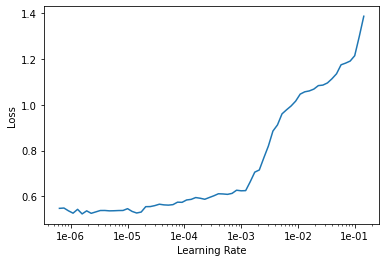

In [16]:
learn.recorder.plot()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.553508,0.596880,0.260714,0.739286,01:51
1,0.581175,0.586555,0.248214,0.751786,01:57
2,0.562805,0.577429,0.246429,0.753571,01:58
3,0.516530,0.569963,0.248214,0.751786,01:59
4,0.539252,0.579662,0.255357,0.744643,01:59
5,0.514574,0.565409,0.237500,0.762500,01:59
6,0.485994,0.562717,0.237500,0.762500,02:00
7,0.491660,0.564577,0.246429,0.753571,02:00
8,0.463535,0.567282,0.251786,0.748214,02:51
9,0.491341,0.554177,0.251786,0.748214,01:52


In [ ]:
interp_2 = ClassificationInterpretation.from_learner(learn)

In [19]:
learn.save('stage-2')

## Test stage 2

In [87]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2243 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Adults,Adults,Adults,Adults
Path: data;

Valid: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Toddler,Adults,Adults,Adults
Path: data;

Test: LabelList (314 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (con

## Resnet 50

In [6]:
np.random.seed(43)
data = ImageDataBunch.from_folder(path,
                                  train='train',
                                  test='test',
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4, bs=8,
                                  no_check=True
                                 ).normalize(imagenet_stats)

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


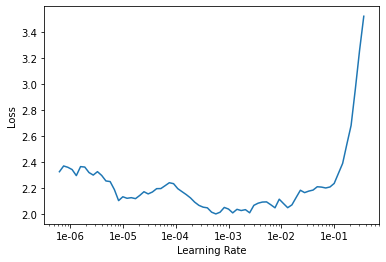

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.653499,1.055275,0.362500,02:30
1,1.132864,0.973872,0.373214,02:33
2,0.995524,0.848867,0.341071,02:42
3,0.888572,0.684920,0.310714,02:39
4,0.756867,0.723560,0.303571,03:22
5,0.728545,0.597932,0.255357,02:41
6,0.638719,0.606120,0.250000,02:39
7,0.601632,0.588933,0.257143,02:40


In [12]:
learn.save('stage-1-50')

In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.573695,0.595460,0.255357,03:31
1,0.641706,0.587663,0.248214,03:33
2,0.622868,0.582576,0.253571,03:33
3,0.557086,0.572770,0.248214,32:29
4,0.553793,0.566135,0.235714,04:40
5,0.546945,0.552628,0.223214,04:38
6,0.543994,0.552358,0.228571,04:36
7,0.552688,0.554052,0.237500,04:25
8,0.501905,0.556193,0.237500,04:28
9,0.570400,0.572382,0.248214,04:39


In [14]:
learn.save('stage-1-50-II')

## Test

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

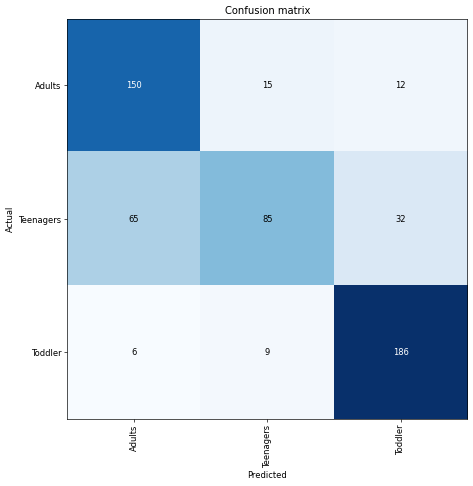

In [19]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

## Predictions with fine tuned Reset50

In [8]:
learn.load('stage-1-50-II')

Learner(data=ImageDataBunch;

Train: LabelList (2243 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Adults,Adults,Adults,Adults
Path: data;

Valid: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Adults,Toddler,Adults,Adults,Adults
Path: data;

Test: LabelList (314 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (con

In [12]:
filenames = pd.read_csv(test_csv)
filenames = np.array(filenames)

In [14]:
res = []
for img in filenames:
    path = os.path.join(test_path, str(img[0]))
    tst = open_image(path)
    pred_class,pred_idx,outputs = learn.predict(tst)
    pred = pred_class.obj
    res.append(pred_class.obj)


In [15]:
res[:5]

['Adults', 'Teenagers', 'Teenagers', 'Teenagers', 'Toddler']

In [18]:
def save_results(results):
    images = pd.read_csv('./data/Test.csv')['Filename']
    with open('resnet50.csv', 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(["Filename", "Category"])
        for i in range(len(images)):
            res = str(results[i])
            img = images[i]
            w.writerow([img, res])
        print("Predictions saved .. ")
            
save_results(res)

Predictions saved .. 
